Data soruce -> https://github.com/CSSEGISandData/COVID-19

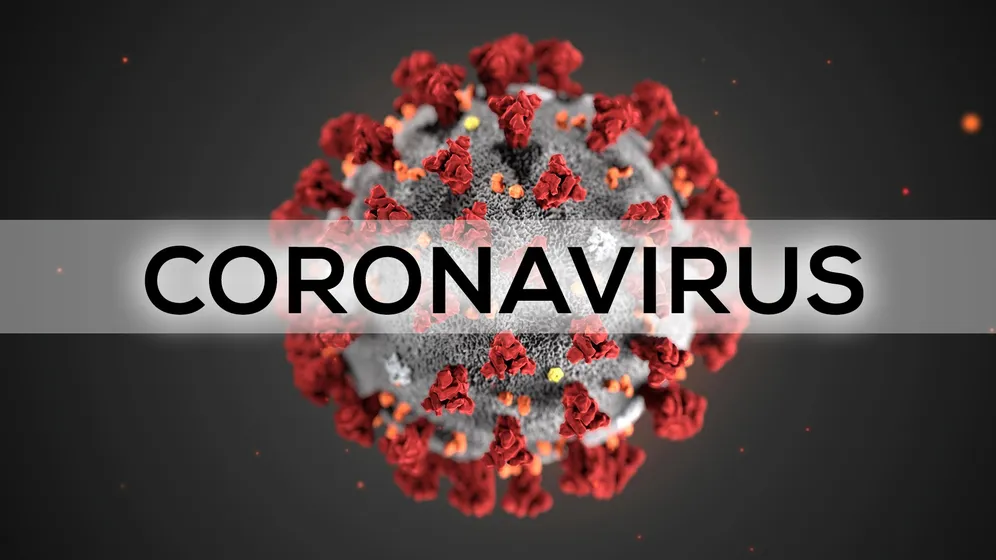

In [1]:
import os
from IPython.display import Image
PATH = '/Users/benai/Desktop/Covid-19/'
Image(filename = PATH + 'covid-img.png')

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

import plotly.graph_objects as go
import plotly.express as px
from ipywidgets import interact, widgets

from scipy.interpolate import interp1d

# increasing the row height
#pd.set_option('max_row', 200)

In [3]:
# loading the dataset

death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
country_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv')

In [4]:
# saving the data in my local as a csv

death_df.to_csv('death.csv', index=False)
confirmed_df.to_csv('confirmed.csv', index=False)
recovered_df.to_csv('recovered.csv', index=False)
country_df.to_csv('country.csv', index=False)

In [5]:
# printing the shape of each dataframe

print("The Shape of death_df is: ", death_df.shape)
print("The Shape of confirmed_df is: ", confirmed_df.shape)
print("The Shape of recovered_df is: ", recovered_df.shape)
print("The Shape of country_df is: ", country_df.shape)

The Shape of death_df is:  (266, 118)
The Shape of confirmed_df is:  (266, 118)
The Shape of recovered_df is:  (253, 118)
The Shape of country_df is:  (188, 14)


In [6]:
# checking for null values
print(death_df.isnull().sum().head(2))
print(country_df.isnull().sum())
# column Province/State   contaim 185 null values, hence we will drop this columns

Province/State    185
Country/Region      0
dtype: int64
Country_Region           0
Last_Update              0
Lat                      2
Long_                    2
Confirmed                0
Deaths                   0
Recovered                0
Active                   0
Incident_Rate            2
People_Tested          188
People_Hospitalized    188
Mortality_Rate           0
UID                      0
ISO3                     2
dtype: int64


In [7]:
# droping the 'Province/State' columns as it containd null values

death_df.drop('Province/State', axis=1, inplace=True)
confirmed_df.drop('Province/State', axis=1, inplace=True)
recovered_df.drop('Province/State', axis=1, inplace=True)
country_df.drop(['People_Tested', 'People_Hospitalized'], axis=1, inplace=True)

In [8]:
# renaming column

death_df.rename(columns={'Country/Region': 'Country'}, inplace=True)
confirmed_df.rename(columns={'Country/Region': 'Country'}, inplace=True)
recovered_df.rename(columns={'Country/Region': 'Country'}, inplace=True)
country_df.rename(columns={'Country_Region': 'Country', 'Long_': 'Long'}, inplace=True)

death_df.head(3)

,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20
0,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,...,95,104,106,109,115,120,122,127,132,136
1,Albania,41.1533,20.1683,0,0,0,0,0,0,0,...,31,31,31,31,31,31,31,31,31,31
2,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,...,470,476,483,488,494,502,507,515,522,529


In [9]:
# un-pivot the dataframe

death_df2 = pd.melt(death_df, id_vars=['Country', 'Lat', 'Long', ], var_name='Date', value_name='Death_no')
confirmed_df2 = pd.melt(confirmed_df, id_vars=['Country', 'Lat', 'Long', ], var_name='Date', value_name='Confirmed_no')
recovered_df2 = pd.melt(recovered_df, id_vars=['Country', 'Lat', 'Long', ], var_name='Date', value_name='Recovered_no')

In [10]:
confirmed_df2.head()

,Country,Lat,Long,Date,Confirmed_no
0,Afghanistan,33.0000,65.0000,1/22/20,0
1,Albania,41.1533,20.1683,1/22/20,0
2,Algeria,28.0339,1.6596,1/22/20,0
3,Andorra,42.5063,1.5218,1/22/20,0
4,Angola,-11.2027,17.8739,1/22/20,0


In [11]:
# change the date to datetype

death_df2['Date'] = pd.to_datetime(death_df2['Date'])
confirmed_df2['Date'] = pd.to_datetime(confirmed_df2['Date'])
recovered_df2['Date'] = pd.to_datetime(confirmed_df2['Date'])

In [12]:
# sorting country_df with highest confirm rate
country_df.sort_values('Confirmed', ascending=False, inplace=True)

In [13]:
# checking for missing values

death_df2.isna().sum()

Country     0
Lat         0
Long        0
Date        0
Death_no    0
dtype: int64

In [14]:
# checking the first five rows of the columns

death_df2.head()

,Country,Lat,Long,Date,Death_no
0,Afghanistan,33.0000,65.0000,2020-01-22,0
1,Albania,41.1533,20.1683,2020-01-22,0
2,Algeria,28.0339,1.6596,2020-01-22,0
3,Andorra,42.5063,1.5218,2020-01-22,0
4,Angola,-11.2027,17.8739,2020-01-22,0


# Daily COVID-19 case report 

In [15]:
# group by country and show data

def country_wise(country_name,df_type, number):
    # on select of category copy the dataframe to group by country
    if df_type == 'Confirmed cases':
        df_type = confirmed_df.copy(deep=True)
        category = 'COVID-19 confirmed cases'
        
    elif df_type == 'Death rate':
        df_type = death_df.copy(deep=True)
        category = 'COVID-19 Death rate'
        
    else:
        df_type = recovered_df.copy(deep=True)
        category = 'COVID-19 recovered cases'
        
    
    # group by country name
    country = df_type.groupby('Country')
    
    # select the given country
    country = country.get_group(country_name)
    
    # store daily death rate along with the date
    daily_cases = []
    case_date = []
    
    # iterate over each row
    for i, cols in enumerate(country):
        if i > 3:
            # take the sum of each column if there are multiple columns
            daily_cases.append(country[cols].sum())
            case_date.append(cols)
            zip_all_list = zip(case_date, daily_cases)
            
            # creata a data frame
            new_df = pd.DataFrame(data = zip_all_list, columns=['Date','coronavirus'])

    # append the country to the data frame
    new_df['Country'] = country['Country'].values[0]
    
    # get the daily death rate
    new_df = get_daily_date(new_df)
      
    # ploting the graph
    fig = px.line(new_df.iloc[-number:] ,
                  x='Date', y='coronavirus',
                  title='Daily ' + category +'  in ' + new_df['Country'].values[0])
    fig.update_layout(title_font_size=26,height=450)
    fig.show()

    return

In [16]:
# give the daily recovered case, death no, comfired cases
def get_daily_date(new_df):
    # calculation to get the no of death,recoverd, comfirmed cases for each day,
    # because each day new cases are added with the previous day cases in the csv
    new_df2 = new_df.copy(deep=True)
    for i in range(len(new_df) -1):
        new_df.iloc[i+1, 1] = new_df.iloc[1+i, 1] - new_df2.iloc[i, 1]
        if new_df.iloc[i+1, 1] < 0:
            new_df.iloc[i+1, 1] = 0
    return new_df

In [17]:
# select the country from the dropdown 
my_df_type = ['Confirmed cases', 'Death rate', 'Recovered cases']
drop_down = widgets.Dropdown(options=confirmed_df['Country'].unique().tolist(),
                                value='India',
                                description='Country',
                                disabled=False)


# slider to choose the number of days data to show
slider = widgets.IntSlider(value=40,
                              min=10,
                              max=len(death_df.columns[3:]),
                              step=1,
                              description='Select Days:',
                              disabled=False,
                              continuous_update=False,
                              orientation='horizontal',
                              readout=True,
                              readout_format='d')

# select the category 
category_drop_down = widgets.Dropdown(options=my_df_type,
                                value='Confirmed cases',
                                description='Category',
                                disabled=False)

# call the method on select or slide occour
interact(country_wise, country_name=drop_down, df_type=category_drop_down, number=slider);




interactive(children=(Dropdown(description='Country', index=71, options=('Afghanistan', 'Albania', 'Algeria', …

# Top 10 Effected countries with COVID-19

In [18]:
# method to get the top 10 countries

def top_ten(number, sort_by):
    # sorting the columns with top death rate
    country_df.sort_values(by=sort_by, ascending=False, inplace=True)

    # sort country with highest number of cases
    fig = px.bar(country_df.head(number),
        x = "Country",
        y = sort_by,
        title= 'Top ' + str(number) +' Country - ' + sort_by + ' case',
        color="Country",
        height=500
    )
    fig.update_layout(title_font_size=26, height=550)
    
    return fig

In [19]:
# dropdown to select no of country and category

drop_down = widgets.Dropdown(options=list(range(1,31)),
                                value=10,
                                description='No Country',
                                disabled=False)

desc = widgets.Dropdown(options=country_df.loc[0:, ['Confirmed', 'Active', 'Deaths', 'Recovered', 'Mortality_Rate']].columns.tolist(),
                        value='Confirmed',
                        description='Category',
                        disabled=False)


interact(top_ten, number=drop_down, sort_by=desc);

interactive(children=(Dropdown(description='No Country', index=9, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, …

# Global view

In [20]:
# fixing the size of circle
margin = country_df['Confirmed'].values.tolist()
circel_range = interp1d([1, max(margin)], [0.2,12])
circle_radius = circel_range(margin)

# ploting the map
fig = px.scatter_mapbox(country_df, lat="Lat", lon="Long", hover_name="Country", hover_data=["Confirmed", "Deaths", 'Recovered'],
                        color_discrete_sequence=["#e60039"], zoom=1.5, height=500, size_max=50, size=circle_radius)
fig.update_layout(mapbox_style="open-street-map", margin={"r":0,"t":0,"l":0,"b":0}, height=450)
fig.show()

# Confirmed vs recovered

In [21]:
# confirmed and recovred cases

top_country = country_df.head(10)
top_country_name = list(top_country['Country'].values)

fig = go.Figure(data=[
    go.Bar(name='Confirmed',marker_color='rgb(100,20,205)', x=top_country_name, y=list(top_country['Confirmed'])),
    go.Bar(name='Recovered', marker_color='red',x=top_country_name, y=list(top_country['Recovered'])),
])

# Change the bar mode
fig.update_layout(barmode='group', height=600, title_text="Top 10 countires with Confirmed and Recovered case")
fig.show()